# Machine Learning with Python - Clustering

##  Introduction

Clustering methods partition a dataset $\mathbb{X} = \{ \mathbf{x}^{(i)} \}_{i=1}^{m}$, consisting of $m$ data points $\mathbf{x}^{(i)} \in \mathbb{R}^{n}$, into a small number of groups or "clusters" $\mathcal{C}_{1},\ldots,\mathcal{C}_{k}$. Each cluster $\mathcal{C}_{l}$ represents a subset of data points which are more similar to each other than to data points in another cluster. The precise meaning of two data points being "similar" depends on the application at hand. 

Clustering methods do not require labeled data and can be applied to data points characterized solely by its features $\mathbf{x}^{(i)}$. Therefore, clustering methods are referred to as **unsupervised** machine learning methods. However, clustering methods are often used in combination (e.g., as a preprocessing step) with supervised learning methods such as regression or classification. 

There are two main flavors of clustering methods: 

* Hard clustering methods assign each data point to exactly one cluster and 
* Soft clustering methods assign each data point to several different clusters with varying degrees of belonging.

Hard clustering can be interpreted as a special case of soft-clustering where the degrees of belonging are enforced to be either 0 (no belonging) or 1 (belongs).

In this exercise we will implement one popular method for hard clustering, the k-means algorithm, and one popular method for soft clustering, which is based on a probabilistic Gaussian mixture model (GMM). These two methods use a notion of similarity that is tied to the Euclidean geometry of $\mathbb{R}^{n}$. 
In some applications, it is more useful to use a different notion of similarity. The hard clustering method DBSCAN is an example of a clustering method which uses a non-Euclidean notion of similarity. 

## The Data

We are running a Cafe in Helsinki and want to segment the customers to find the best marketing strategy for the next summer. Such a customer segmentation can be done efficiently using __clustering methods__. 


The file "data.csv" contains $m=400$ rows representing the data points $\mathbf{x}^{(i)}=
\big( x_{1}^{(i)},x_{2}^{(i)} \big)$, for $i=1,\ldots,m$. The first column of the $i$-th row in the file contains the age $x_{1}^{(i)}$ of the $i$-th customer. The second column contains the amount $x_{2}^{(i)}$ of money spent by the $i$-th customer.

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Loading the Data. 
 

The following code snippet reads in $m=400$ data points from the csv file "data.csv". Data points are represtend by feature vectors $\mathbf{x}^{(i)} \in \mathbb{R}^{n}$, with $n=2$, for $i=1,\ldots,m=400$. The feature vectors are stacked into the data matrix 
$$\mathbf{X}= \big( \mathbf{x}^{(1)},\ldots,\mathbf{x}^{(m)} \big)^{T} \in  \mathbb{R}^{m \times n} \tag{EqDataMtx}$$ and then depicted using a scatter plot.

   </div>

In [1]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

#read in data from the csv file and store it in the numpy array data.
df = pd.read_csv("data.csv")
data = np.array(df)

#display first 5 rows
display(df.head(5))  

,Age,Spending
0,28.018868,5.263333
1,27.897623,5.276452
2,29.042011,4.794357
3,29.669165,5.207227
4,29.494291,6.351539


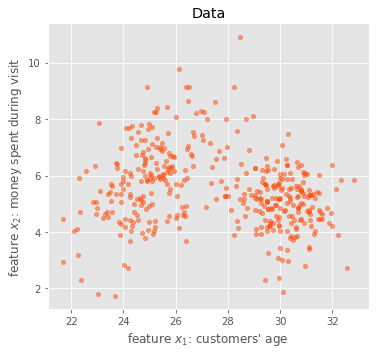

In [2]:
def plotting(data, centroids=None, clusters=None):
    #this function will later on be used for plotting the clusters and centroids. But now we use it to just make a scatter plot of the data
    #Input: the data as an array, cluster means (centroids), cluster assignemnts in {0,1,...,k-1}   
    #Output: a scatter plot of the data in the clusters with cluster means
    plt.figure(figsize=(5.75,5.25))
    data_colors = ['orangered','dodgerblue','springgreen']
    plt.style.use('ggplot')
    plt.title("Data")
    plt.xlabel("feature $x_1$: customers' age")
    plt.ylabel("feature $x_2$: money spent during visit")

    alp = 0.5             # data points alpha
    dt_sz = 20            # marker size for data points 
    cent_sz = 130         # centroid sz 
    
    if centroids is None and clusters is None:
        plt.scatter(data[:,0], data[:,1],s=dt_sz,alpha=alp ,c=data_colors[0])
    if centroids is not None and clusters is None:
        plt.scatter(data[:,0], data[:,1],s=dt_sz,alpha=alp, c=data_colors[0])
        plt.scatter(centroids[:,0], centroids[:,1], marker="x", s=cent_sz, c=centroid_colors[:len(centroids)])
    if centroids is not None and clusters is not None:
        plt.scatter(data[:,0], data[:,1], c=[data_colors[i-1] for i in clusters], s=dt_sz, alpha=alp)
        plt.scatter(centroids[:,0], centroids[:,1], marker="x", c=centroid_colors[:len(centroids)], s=cent_sz)
    if centroids is None and clusters is not None:
        plt.scatter(data[:,0], data[:,1], c=[data_colors[i-1] for i in clusters], s=dt_sz, alpha=alp)
    
    plt.show()

#plot the data
plotting(data)   

# Hard Clustering

Hard clustering partitions a data set $\mathbb{X}=\{\mathbf{x}^{(1}),\ldots,\mathbf{x}^{(m)}\}$ into $k$ non-overlapping clusters $\mathcal{C}_1,\ldots,\mathcal{C}_k$. Each data point is assigned to precisely one cluster. We denote by $y^{(i)} \in \{1,\ldots,k\}$ the index of the cluster to which the $i$th data point $\mathbf{x}^{(i)}$ belongs to. 

The formal setup of hard clustering is quite similar to that of classification methods. We can interpret the cluster index $y^{(i)}$ as the label (quantity of interest) associated with the $i$:th data point. In contrast to classification problems, clustering methods do not require any labeled data points. 

Clustering methods do not require knowledge of the **true cluster assignment** for any data point. Instead, clustering methods learn a reasonable cluster assignment for a data point based on the intrinsic geometry of the entire dataset $\mathbb{X}$. Therefore, clustering methods are referred to as **unsupservised meachine learning** methods since they do not need supervision in the form of labeled provided by some data points. 



## The k-Means Algorithm

A popular method for hard clustering is the k-means algorithm which takes as input a list of data points $\mathbb{X}= \{ \mathbf{x}^{(1)},...,\mathbf{x}^{(m)} \}$ and groups them into $k$ non-overlapping clusters $\mathcal{C}_{¡},\ldots,\mathcal{C}_{k}$. Each (non-empty) cluster $\mathcal{C}_{c} \subseteq \mathbb{X}$ is characterized by the cluster mean 

\begin{equation*}
\mathbf{m}^{(c)} = (1/|\mathcal{C}_{c}|) \sum_{\mathbf{x}^{(i)} \in \mathcal{C}_{c}} x^{(i)}. 
\end{equation*}

If we would know the cluster means $\mathbf{m}^{(c)}$ for each cluster, we could assign each data point $\mathbf{x}^{(i)}$ to the cluster with index $y^{(i)}$ whose mean is nearest: 
\begin{equation}
\| \mathbf{x}^{(i)} - \mathbf{m}^{y^{(i)}} \| = {\rm min}_{c \in \{1,\ldots,k\}}\| \mathbf{x}^{(i)} - \mathbf{m}^{(c)} \|. 
\end{equation} 
However, in order to determine the cluster means $\mathbf{m}^{(c)}$, we would have needed the cluster assignments $y^{(i)}$ already in the first place. This instance of an [egg-chicken dilemma](https://en.wikipedia.org/wiki/Chicken_or_the_egg) is resolved by the $k$-means algorithm as follows:

* __Input__: data points $\mathbf{x}^{(i)} \in \mathbb{R}^{n}$, for $i=1,\ldots,m$ and number $k$ of clusters


* __Initialization__: choose initial cluster means $\mathbf{m}^{(1)},\ldots,\mathbf{m}^{(k)} \in \mathbb{R}^{n}$


* __Repeat Until Stopping Condition is Met:__  

    * __Update Cluster Assignments__: assign each data to the nearest cluster: 
    
    for each data point $i=1,\ldots,m$, set  
    
    \begin{equation*}
    y^{(i)} = \underset{c' \in \{1,\ldots,k\}}{\operatorname{argmin}} \|\mathbf{x}^{(i)} - \mathbf{m}^{(c')}\|^2 , 
    \tag{1}
    \end{equation*}
    
    * __Update Cluster Means__: determine cluster means for new cluster assignments 
    
    for each cluster $c=1,\ldots,k$, set 
    \begin{equation*}
    \mathbf{m}^{(c)} = \frac{1}{\mid\{i: y^{(i)}= c\}\mid}{\sum_{i: y^{(i)}= c}\mathbf{x}^{(i)}}     
    \label{mean}
    \tag{2}
    \end{equation*}
    where $\{i: y^{(i)}= c\}$ represents the set of datapoints belonging to cluster c and $\mid\{i: y^{(i)}= c\}\mid$ the size of cluster c.  
    


The working of $k$-means is best understood by walking through an example. To this end, we apply the $k$-means algorithm to the customer data discussed above.

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Apply k-means. 

The code snippet below uses k-means to cluster the Cafe customers into $k=3$ clusters $\mathcal{C}_{1}$,$\mathcal{C}_{2}$ and $\mathcal{C}_{3}$. The resulting clusters are depicted in a scatter plot by using the same color for all data points in the same cluster. The cluster means (centers) $\mathbf{m}^{(1)}$, $\mathbf{m}^{(2)}$ and $\mathbf{m}^{(3)}$ are represnted by crosses.   

 </div>

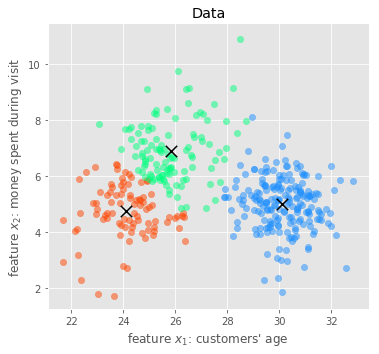

In [3]:
from sklearn.cluster import KMeans

X = np.zeros([400,2])               # read the Cafe customer data into X
cluster_means = np.zeros([2,2])     # store the resulting clustering means in the rows of this np array
cluster_indices = np.zeros([400,1]) # store here the resulting cluster indices (one for each data point)
data_colors = ['orangered','dodgerblue','springgreen'] # colors for data points
centroid_colors = ['red','darkblue','limegreen'] # colors for the centroids

X = data      # read in cafe costumer data point into numpy array X of shape (400,2)
k_means = KMeans(n_clusters = 3, max_iter = 100).fit(X) # apply k-means with k=3 cluster and using 100 iterations
cluster_means = k_means.cluster_centers_         # read out cluster means (centers)
cluster_indices = k_means.labels_                # read out cluster indices for each data point
cluster_indices = cluster_indices.reshape(-1,1)  # enforce numpy array cluster_indices having shape (400,1)

# code below creates a colored scatterplot 

plt.figure(figsize=(5.75,5.25))
plt.style.use('ggplot')
plt.title("Data")
plt.xlabel("feature $x_1$: customers' age")
plt.ylabel("feature $x_2$: money spent during visit")

alp = 0.5             # data points alpha
dt_sz = 40            # marker size for data points 
cent_sz = 130         # centroid sz 
       
# iterate over all cluster indices (minus 1 since Python starts indexing with 0)
for cluster_index in range(3):
    # find indices of data points which are assigned to cluster with index (cluster_index+1)
    indx_1 = np.where(cluster_indices == cluster_index)[0] 

    # scatter plot of all data points in cluster with index (cluster_index+1)
    plt.scatter(X[indx_1,0], X[indx_1,1], c=data_colors[cluster_index], s=dt_sz, alpha=alp) 
    

# plot crosses at the locations of cluster means 

plt.scatter(cluster_means[:,0], cluster_means[:,1], marker="x", c='black', s=cent_sz)
    
plt.show()

<a id='handsondata'></a>
<div class=" alert alert-warning">
    <b>Apply k-means.</b> 
 

Reading in the Cafe customer data into the numpy array `X` of shape (400,2). Then, applying the k-means algorithm via the `scikit-learn` function `KMeans`. The function allows to specify the number of clusters and number of iterations with the input parameters `n_clusters` and `max_iter`.I Used `max_iter=10` so that the function alternatingly updates the cluster assignment and cluster means $10$ times. Applying k-means with $k=2$ clusters by setting the input parameter `n_clusters=2`.I do not set any other input parameter so that their default values are used. 

Stored the resulting cluster means in the numpy array `cluster_means` of shape (2,2) and the resulting cluster assignments in the numpy array `cluster_indices` of shape (400,1). 

[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

 </div>

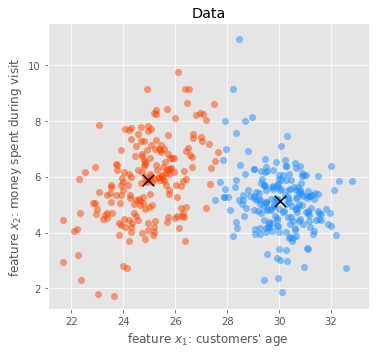

The final cluster mean values are:
 [[24.94326652  5.87406858]
 [30.03164456  5.13271688]]


In [4]:
from sklearn.cluster import KMeans

X = np.zeros([400,2])               # read the Cafe customer data into X
cluster_means = np.zeros([2,2])     # store the resulting clustering means in the rows of this np array
cluster_indices = np.zeros([400,1]) # store here the resulting cluster indices (one for each data point)

### STUDENT TASK ###
# YOUR CODE HERE

X = data                                  # read in cafe costumer data point into numpy array X of shape (400,2)
k_means = KMeans(n_clusters = 2, max_iter = 10).fit(X) # apply k-means with k=3 cluster and using 100 iterations
cluster_means = k_means.cluster_centers_         # read out cluster means (centers)
cluster_indices = k_means.labels_                # read out cluster indices for each data point
cluster_indices = cluster_indices.reshape(-1,1)  # enforce numpy array cluster_indices having shape (400,1)

plt.figure(figsize=(5.75,5.25))
plt.style.use('ggplot')
plt.title("Data")
plt.xlabel("feature $x_1$: customers' age")
plt.ylabel("feature $x_2$: money spent during visit")

alp = 0.5             # data points alpha
dt_sz = 40            # marker size for data points 
cent_sz = 130         # centroid sz 
       

#iterate over all cluster indices (minus 1 since Python starts indexing with 0)
for cluster_index in range(2):
    # find indices of data points which are assigned to cluster with index (cluster_index+1)
    indx_1 = np.where(cluster_indices == cluster_index)[0]
    #print(indx_1)

    # scatter plot of all data points in cluster with index (cluster_index+1)
    plt.scatter(X[indx_1,0], X[indx_1,1], c=data_colors[cluster_index], s=dt_sz, alpha=alp) 
    
plt.scatter(cluster_means[:,0], cluster_means[:,1], marker="x", c='black', s=cent_sz)
    
plt.show()

#raise NotImplementedError()

#print(type(cluster_indices))
#plotting(X,cluster_means,cluster_indices)
print("The final cluster mean values are:\n",cluster_means)

## Handling Local Minima

The k-means algorithm can be interpreted as method for minimizing the **clustering error**: 
$$\mathcal{E}  ( \{\mathbf{m}^{(c)}\}_{c=1}^{k},\{y^{(i)}\}_{i=1}^{m} \mid \{\mathbf{x}^{(i)}\}_{i=1}^{m} )
=(1/m) \sum_{i=1}^{m} {\left\|\mathbf{x}^{(i)}-\mathbf{m}^{(y^{(i)})}\right\|^2}. 
\label{EqErr}
\tag{3}
$$
Indeed, the k-means updates amount to alternatingly optimization of $\mathcal{E}  ( \{\mathbf{m}^{(c)}\}_{c=1}^{k},\{y^{(i)}\}_{i=1}^{m} \mid \{\mathbf{x}^{(i)}\}_{i=1}^{m} )$ over varying choices for cluster means $\mathbf{m}^{(c)}$ with cluster assignments $y^{(i)}$ held fixed and vice-versa. 

The optimization interpretation of k-Means allows to define a criterion for when to stop iterating the cluster assignment and means updates. The input paramter `tol` of the Python function `KMeans` allows to specify a relative value of objective decrease that is used to declare convergence (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)). However, in this exercise a simpler approach of using a fixed number of iterations used by k-Means. 

Since the clustering error is a non-convex function of the cluster means and assignments, the k-means method might get trapped in a **local minimum**. It is therefore useful to repeat k-means **several times with different initializations** for the cluster means and choose the cluster assignment resulting in the smallest empirical risk among all repetitions. 

<div class="alert alert-warning">

<b> Repeat $k$-means To Escape Local Minima.</b> 

Repeat $k$-means $50$ times using $k=3$ clusters and $L=10$ iterations in each repetition. In the $r$th repetition use the $r$-th row of the numpy arrays `init_mean_cluster1`, `init_mean_cluster2`, `init_mean_cluster3` as initial cluster means for the Python function `KMeans`. 
The cluster assignments obtained from those two repetitions achieving the smallest and largest clustering error should be stored in the numpy array `best_assignment` and `worst_assignment` each of shape (400,1). The index (starting at 0) of the repetition yielding the smallest clustering error should be stored in the variable `min_ind`. The index (starting at 0) of the repetition yielding the largest clustering error should be stored in the variable `max_ind`. 

Hint: the clustering error obtained by using the `KMeans` class of `scikit-learn` can be accessed via the attribute `KMeans.inertia_`. 

</div>

/home/luqmon/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/home/luqmon/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/home/luqmon/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/home/luqmon/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
/home/luqmon/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: RuntimeWarning: Explicit initial cen

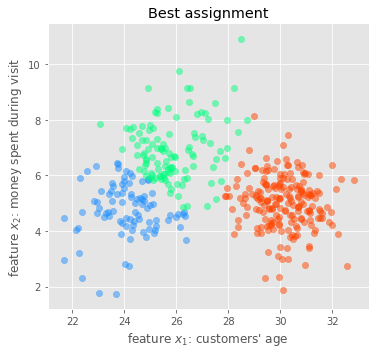

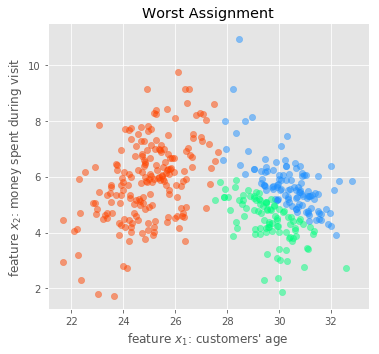

In [5]:
# Student Task

min_ind= 0  # store here the index of the repetition yielding smallest clustering error 
max_ind= 0  # .... largest clustering error

# initializing the array where we collect all cluster assignments  
cluster_assignment = np.zeros((50, data.shape[0]),dtype=np.int32)

clustering_err = np.zeros([50,1]) # init numpy array for storing the clustering errors in each repetition

np.random.seed(42)   ###  DO NOT CHANGE THIS LINE !!!

init_means_cluster1 = np.random.randn(50,2)  # use the rows of this numpy array to init k-means 
init_means_cluster2 = np.random.randn(50,2)  # use the rows of this numpy array to init k-means 
init_means_cluster3 = np.random.randn(50,2)  # use the rows of this numpy array to init k-means 

best_assignment = np.zeros((400,1))     # store here the cluster assignment achieving smallest clustering error
worst_assignment = np.zeros((400,1))    # store here the cluster assignment achieving largest clustering error
# YOUR CODE HERE


for r in range(50):
    init = np.array([init_means_cluster1[r], init_means_cluster2[r], init_means_cluster3[r]])
    k_means = KMeans(n_clusters = 3, init=init, max_iter = 10).fit(X) # apply k-means with k=3 cluster and using 100 iterations
    cluster_assignment[r] = k_means.labels_         # read out cluster means (centers)
    clustering_err[r] = k_means.inertia_
    #print(k_means.labels_.reshape(1,-1).shape)
    #print(clustering_err)


    
    
    
    
min_ind = np.where(min(clustering_err) == clustering_err)[0]
max_ind = np.where(max(clustering_err) == clustering_err)[0]

best_assignment = cluster_assignment[min_ind]
worst_assignment = cluster_assignment[max_ind]




plt.figure(figsize=(5.75,5.25))
plt.style.use('ggplot')
plt.title("Best assignment")
plt.xlabel("feature $x_1$: customers' age")
plt.ylabel("feature $x_2$: money spent during visit")


#iterate over all cluster indices (minus 1 since Python starts indexing with 0)
for cluster_index in range(3):
    # find indices of data points which are assigned to cluster with index (cluster_index+1)
    indx_1 = (best_assignment == cluster_index)[0]
    #print(indx_1)

    # scatter plot of all data points in cluster with index (cluster_index+1)
    plt.scatter(X[indx_1,0], X[indx_1,1], c=data_colors[cluster_index], s=dt_sz, alpha=alp) 
    
#plt.scatter(cluster_means[:,0], cluster_means[:,1], marker="x", c='black', s=cent_sz)
    
plt.show()



plt.figure(figsize=(5.75,5.25))
plt.style.use('ggplot')
plt.title("Worst Assignment")
plt.xlabel("feature $x_1$: customers' age")
plt.ylabel("feature $x_2$: money spent during visit")



for cluster_index in range(3):
    # find indices of data points which are assigned to cluster with index (cluster_index+1)
    indx_1 = (worst_assignment == cluster_index)[0]
    #print(indx_1)

    # scatter plot of all data points in cluster with index (cluster_index+1)
    plt.scatter(X[indx_1,0], X[indx_1,1], c=data_colors[cluster_index], s=dt_sz, alpha=alp) 
    
#plt.scatter(cluster_means[:,0], cluster_means[:,1], marker="x", c='black', s=cent_sz)
    
plt.show()


#raise NotImplementedError()


#print("Cluster assignment with smallest clustering error")
#plotting(data, clusters = cluster_assignment[min_ind, :])
#print("Cluster assignment with largest clustering error")
#plotting(data, clusters = cluster_assignment[max_ind,:])

## How Many Clusters ? 

Sometimes it is not clear what a good choice for the number $k$ of clusters should be. One (data-driven) way to choose $k$ is to run k-means for increasing values of $k$ until the clustering error is below a prescribed level (say $10$ percent).  

<div class="alert alert-warning">

<b> Try out different number $k$ of clusters.</b>  


Apply k-means to the Cafe customer data for the choices $k=1,\ldots,8$. For each choice of $k$, run KMeans once with $L=100$ iterations. Store the resulting clustering error in the numpy array `err_clustering` of shape (8,1).  

</div>

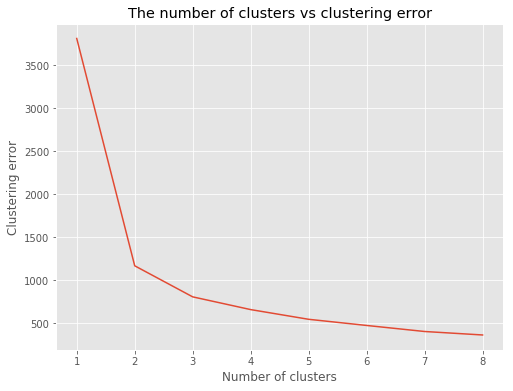

In [6]:


data_num = data.shape[0]
err_clustering = np.zeros([8,1])


for i in range(1,9):
    k_means = KMeans(n_clusters = i, max_iter = 100).fit(X) 
    err_clustering[i-1] = k_means.inertia_

fig=plt.figure(figsize=(8,6))
plt.plot(range(1,9),err_clustering)
plt.xlabel('Number of clusters')
plt.ylabel('Clustering error')
plt.title("The number of clusters vs clustering error")
plt.show()    

# Soft Clustering 

The information provided by the cluster assignments $y^{(i)}$, for $i=1,\ldots,m$, delivered by $k$-means is rather coarse-grained. Even if two data points belong to the same cluster, their location within the cluster might be very different. Consider the data set whose scatter plot is shown below. The data points represented by blue dots that lie outside the biggest circle are somewhat in-between different clusters. However, the cluster assignments delivered by k-means do not reflect the different locations of data points relative to the center of the cluster. In some applications it is useful to measure the degree of a data point belonging to a cluster. 

<center>
    <img src="graph_example.png" alt="Example of not good hard-clustering"/>
</center>

##  Gaussian Mixture Models 

Let us now consider soft-clustering methods which provide a more fine-grained information about the cluster structure of a data set. For the customer segmentation for a Cafe business, we might need some measure for the extend (or degree) by which a customer belongs to various groups. Soft-clustering methods associate each data point $\mathbf{x}^{(i)}$ with a "cluster-membership" vector $\mathbf{y}^{(i)}= (y^{(i)}_1,...,y^{(i)}_k) \in [0,1]^k$. The entry $y^{(i)}_c$ is the degree of confidence by which we assign $\mathbf{x}^{(i)}$ to cluster $\mathcal{C}_c$. 

A principled approach to soft-clustering is based on interpreting data points $\mathbf{x}^{(i)}$ as realizations of a random vector $\mathbf{x}$ with probability distribution $p(\mathbf{x})$. Soft-clustering assumes that each data points is obtained by randomly drawing from one of $k$ different clusters. Each cluster $\mathcal{C}_{c}$ corresponds to a [Gaussian random vector](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) with some mean vector $\mathbf{\mu}^{(c)}$ and covariance matrix $\mathbf{C}^{(c)}$. The probability density function (pdf) of a Gaussian random vector $\mathbf{z}$ with mean $\mu$ and covariance metrix $\mathbf{C}$ is denoted 
\begin{equation}
\mathcal{N}(\mathbf{x} ; \mathbf{\mu}, \mathbf{C}) = \frac{1}{\sqrt{{\rm det} \big(2 \pi \mathbf{C}\big)}} {\rm exp } \bigg( - \big(\mathbf{z} - \mathbf{\mu} \big)^{T} \mathbf{C}^{-1}  \big(\mathbf{z} - \mathbf{\mu}\big)\bigg).
\end{equation}
Note that this expression is only valid for Gaussian random vectors having a non-singular (invertible) covariance matrix $\mathbf{C}$. The resulting pdf of a data point is a **Gaussian mixture model (GMM)**  
\begin{equation}
p(\mathbf{x}) = \sum_{c=1}^{k} p_{c} \mathcal{N}(\mathbf{x};\mathbf{\mu}^{(c)},\mathbf{C}^{(c)}). 
\end{equation}
The coefficients $p_{c} \geq 0$ are required to satisfy $\sum_{c=1}^{k}p_c=1$ and represent the (prior) probability that a data point is drawn from cluster $\mathcal{C}_{c}$. 

Note that the GMM $p(\mathbf{x})$ is parametrized by 

* the cluster probabilities $p_{1},p_{2}, ..., p_k$, 
* the cluster means $\mathbf{\mu}^{(1)},\mathbf{\mu}^{(2)},..., \mathbf{\mu}^{(k)}$ 
* and the covariance matrices $\mathbf{C}^{(1)},\mathbf{C}^{(2)},..., \mathbf{C}^{(k)}$.

Using the GMM $p(\mathbf{x})$, we can make the notion of a degree of belonging precise. In particular, we define the degree $y_{c}^{(i)}$ of a data point $\mathbf{x}^{(i)}$ belonging to cluster $\mathcal{C}_{c}$ as the (posterior) probability that $\mathbf{x}^{(i)}$ is generated (drawn) from the Gaussian distribution associated with $\mathcal{C}_{c}$:  

$$\mathbf{y}^{(i)}_c = \frac{p_{c} \mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{\mu}^{(c)}, \mathbf{C}^{(c)})}{\sum_{c'=1}^k p_{c'} \mathcal{N}(\mathbf{x}^{(i)} ; \mathbf{\mu}^{(c')}, \mathbf{C}^{(c')})} $$

After determining the degrees of belonging $\mathbf{y}^{(i)}_c$, we can update our guess for (estimate of) the cluster probabilities $p_{c}$, cluster means $\mathbf{\mu}^{(c)}$ and covariance matrix $\mathbf{C}^{(c)}$.

In summary this algorithm consists of 4 steps:

* __Step 1 - Initialize the cluster parameters. These are the means and covariances for every cluster.__
* __Step 2 - Update the degree of data point $\mathbf{x}^{(i)}$ belonging to cluster c.__
* __Step 3 - Update cluster probabilities $p_{c}$, means $\mathbf{\mu}^{(c)}$ and covariances $\mathbf{C}^{(c)}$.__
* __Step 4 - If stopping criterion is not satisfied, go to step 2__

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Plotting GMM. 

The code snippet below implements a helper-function `plot_GMM()` which can be used to illustrate GMM along with the scatterplot of data points.

  </div>

In [9]:
def plot_GMM(data,means,covariances,k,cluster_vectors=None):
    
    ## Select three colors for the plot
    # if you want to plot curves k>3, extend these lists of colors
    data_colors = ['orangered','dodgerblue','springgreen'] # colors for data points
    centroid_colors = ['red','darkblue','limegreen'] # colors for the centroids
    
    if cluster_vectors is None:
        plt.scatter(data[:,0], data[:,1], s=13,alpha=0.5)
    else:
        clusters = np.argmax(cluster_vectors,axis=0)
        plt.scatter(data[:,0], data[:,1], c=[data_colors[i] for i in clusters], s=13,alpha=0.5)

    #Visualization of results
    x_plot = np.linspace(19,35, 100)
    y_plot = np.linspace(0,12, 100)

    for i in range(k):
        x_mesh, y_mesh = np.meshgrid(x_plot, y_plot)
        
        pos = np.empty(x_mesh.shape + (2,))
        pos[:,:,0] = x_mesh; pos[:,:,1] = y_mesh
        z = multivariate_normal(mean = [means[i,0],means[i,1]],\
                                cov = [[np.sqrt(covariances[i,0, 0]), covariances[i,0,1]],[covariances[i,0,1], np.sqrt(covariances[i,1, 1])]]).pdf(pos)

        
        plt.contour(x_mesh , y_mesh , z,4,colors=centroid_colors[i],alpha=0.5)
        plt.scatter( [means[i,0]], [means[i,1]], marker='x',c=centroid_colors[i])

    plt.title("Soft clustering with GMM")
    plt.xlabel("feature x_1: customers' age")
    plt.ylabel("feature x_2: money spent during visit")
    plt.show()

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Fitting a GMM to Data. 

The code snippet fits a GMM to the Cafe customer data.  

  </div>


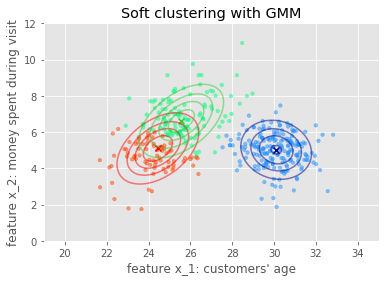

The means are:
 [[24.44383742  5.09735276]
 [30.09856532  5.02230325]
 [25.56729869  6.61059304]]
The covariance matrices are:
 [[[ 1.42380838  0.53377848]
  [ 0.53377848  1.46745733]]

 [[ 1.00796604 -0.11777607]
  [-0.11777607  0.87307784]]

 [[ 1.76383786  0.68441038]
  [ 0.68441038  1.79067615]]]


In [10]:
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal # Multivariate normal random variable


# the following are helper functions to compute, for each data piont, the degrees of belonging to various clusters for each data point 

def belonging_num(data_point, mean_point, covariance_matrix, coefficient_number):
    belonging_num = coefficient_number*multivariate_normal.pdf(data_point, mean_point, covariance_matrix)
    return belonging_num

# helper function for computing the denominator of (EqDoB)
def belonging_den(data_point, means, covariances, coefficients, k):
    belonging_all=np.sum([belonging_num(data_point, means[f], covariances[f], coefficients[f]) for f in range(k)])
    return belonging_all

def update_degrees_of_belonging(data, means, covariances,coefficients,k): 
    cluster_vectors=np.zeros((k,data.shape[0]))   
    for i in range(data.shape[0]):
        belonging_all = belonging_den(data[i], means, covariances, coefficients, k)
        for t in range(k):
            cluster_vectors[t,i]=belonging_num(data[i], means[t], covariances[t], coefficients[t])/belonging_all
    return cluster_vectors


k = 3
gmm = GaussianMixture(n_components = k, max_iter = 50).fit(data)


cluster_vectors = update_degrees_of_belonging(data, gmm.means_, gmm.covariances_, gmm.weights_, k)
plot_GMM(data, gmm.means_, gmm.covariances_, 3, cluster_vectors)
print("The means are:\n",gmm.means_)
print("The covariance matrices are:\n",gmm.covariances_)

# Density Based Clustering

Both k-means and GMM cluster data points according to their Euclidean distance. These methods judge the simiarity between two data points solely based on their Euclidean distance. In some applications, the data conforms to a different non-Euclidean structure. 

One important non-Euclidean structure is based on the notion of connectivity. Here, two data points are considered similar if they can be reached by intermediate data points that have a small Euclidean distance. Two data points can be similar even if their Euclidean distance is large.

<img src="DBSCAN.png" alt="Drawing" style="width: 500px;height: 200px"/>


**Density-based spatial clustering of applications with noise (DBSCAN)** is a hard clustering method that uses a connectivity based similarity measure. In contrast to k-means and GMM, DBSCAN does not require the number of clusters as an argument; the number of clusters used depends its parameters. Moreover, DBSCAN allows to detect outliers  which can be interpreted as degenerated clusters consisting of exactly one data point. For a detailed discussion of how DBSCAN works, we refer to https://en.wikipedia.org/wiki/DBSCAN   

<img src="DBSCAN_tutorial.gif" alt="Drawing" style="width: 500px;"/>

DBSCAN is implemented in the Python function `DBSCAN.fit_predict()` [Documentation can be found here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). DBSCAN requires specification of two design parameters  `eps` and `min_samples`. The meaning of these parameter are well explained [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). 
The DBSCAN implementation `fit_predict(self, X[, y, sample_weight])` returns cluster labels.

<a id='handsondata'></a>
<div class=" alert alert-info">
    <b>Demo.</b> Generating Two Datasets with Different Structure. 

The code snippet below creates two datasets $\mathbb{X}^{(1)}$ and $\mathbb{X}^{(2)}$ which are stored in the numpy arrays `dataset1` and `dataset2`. 

  </div>


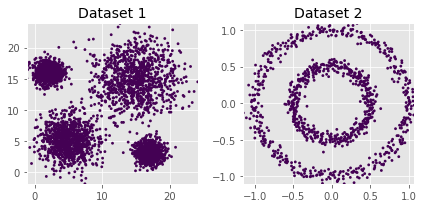

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph

np.random.seed(844)
clust1 = np.random.normal(5, 2, (1000,2))
clust2 = np.random.normal(15, 3, (1000,2))
clust3 = np.random.multivariate_normal([17,3], [[1,0],[0,1]], 1000)
clust4 = np.random.multivariate_normal([2,16], [[1,0],[0,1]], 1000)

dataset1 = np.concatenate((clust1, clust2, clust3, clust4))

# we take the first array as the second array has the cluster labels
dataset2 = datasets.make_circles(n_samples=1000, factor=.5, noise=.05)[0]

# plot clustering output on the two datasets
def cluster_plots(set1, set2, colours1, colours2, 
                  title1 = 'Dataset 1',  title2 = 'Dataset 2'):
    colours1 = colours1.reshape(-1,)
    colours2 = colours2.reshape(-1,)
    fig,(ax1,ax2) = plt.subplots(1, 2)
    fig.set_size_inches(6, 3)
    ax1.set_title(title1,fontsize=14)
    ax1.set_xlim(min(set1[:,0]), max(set1[:,0]))
    ax1.set_ylim(min(set1[:,1]), max(set1[:,1]))
    ax1.scatter(set1[:, 0], set1[:, 1],s=8,lw=0,c=colours1)
    ax2.set_title(title2,fontsize=14)
    ax2.set_xlim(min(set2[:,0]), max(set2[:,0]))
    ax2.set_ylim(min(set2[:,1]), max(set2[:,1]))
    ax2.scatter(set2[:, 0], set2[:, 1],s=8,lw=0,c=colours2)
    fig.tight_layout()
    plt.show()

cluster_plots(dataset1, dataset2,np.ones([dataset1.shape[0],1]),np.ones([dataset2.shape[0],1]))

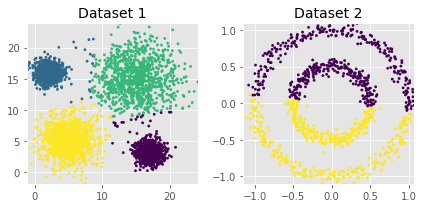

In [12]:
# implementing k-means clustering using sklearn
from sklearn import cluster

kmeans_dataset1 = cluster.KMeans(n_clusters=4, max_iter=300, init='k-means++',n_init=10).fit_predict(dataset1)
kmeans_dataset2 = cluster.KMeans(n_clusters=2, max_iter=300, init='k-means++',n_init=10).fit_predict(dataset2)
cluster_plots(dataset1, dataset2, kmeans_dataset1, kmeans_dataset2)

<div class="alert alert-warning">

<b> Clustering with DBSCAN.</b>  

Apply DBSCAN to the two datasets $\mathbb{X}^{(1)}$ and $\mathbb{X}^{(2)}$ stored in the numpy arrays `dataset1` and `dataset2`.
Use the parameter choices `min_samples=5`, `metric='euclidean'` and `eps` value $1$ for $\mathbb{X}^{(1)}$ and value $0.1$ for dataset $\mathbb{X}^{(2)}$. 
Use the `fit_predict(dataset)` method to obtain the cluster assignments for the data points in each of the two data sets and store them in the numpy arrays `dbscan_dataset1` and `dbscan_dataset2`, respectively. 

* `dbscan_dataset1` should be of dimensions $4000 \times 1$

* `dbscan_dataset2` should be of dimensions $1000 \times 1$

* for each dataset, count the number of data points whose cluster index is `-1` and store them in the variables `dataset1_noise_points` and `dataset2_noise_points`. 


</div>

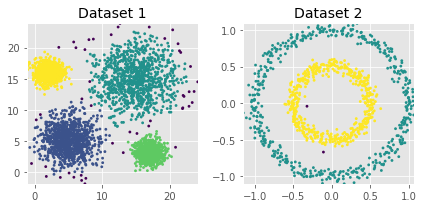

(4000, 1)
Dataset1:
Number of Noise Points: 47 (4000)
Dataset2:
Number of Noise Points: 2 (1000)


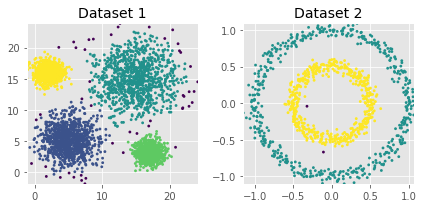

In [13]:
# implementing DBSCAN
from sklearn.cluster import DBSCAN

### STUDENT TASK ###


dbscan_dataset1 = cluster.DBSCAN(eps=1,min_samples=5).fit_predict(dataset1).reshape(-1,1)
dbscan_dataset2 = cluster.DBSCAN(eps=.1,min_samples=5).fit_predict(dataset2).reshape(-1,1)
cluster_plots(dataset1, dataset2, dbscan_dataset1, dbscan_dataset2)

dataset1_noise_points=0
for i in range(dbscan_dataset1.shape[0]):
    index = np.where(dbscan_dataset1[i] == -1)[0]
    dataset1_noise_points += len(index)

dataset2_noise_points=0
for i in range(dbscan_dataset2.shape[0]):
    index = np.where(dbscan_dataset2[i] == -1)[0]
    dataset2_noise_points += len(index)


# YOUR CODE HERE
#raise NotImplementedError()

print(dbscan_dataset1.shape)
print('Dataset1:')
print("Number of Noise Points: ",dataset1_noise_points," (",len(dbscan_dataset1),")",sep='')
print('Dataset2:')
print("Number of Noise Points: ",dataset2_noise_points," (",len(dbscan_dataset2),")",sep='')

cluster_plots(dataset1, dataset2, dbscan_dataset1, dbscan_dataset2)